# Modelo MLP para Previsão de Preços de Criptomoedas (Refatorado)

## Importação das Bibliotecas

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, PReLU, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
import joblib

## Funções do Pipeline

In [3]:
def carregar_dados(caminho_arquivo, ultimas_linhas=100000):
    """
    PASSO 1: Carrega e prepara os dados.
    Objetivo: Ler o arquivo CSV e garantir que ele esteja em ordem.
    """
    # Carrega os dados do arquivo CSV
    df = pd.read_csv(caminho_arquivo)

    # Evita o PC de explodir com muitos dados
    df = df.iloc[-ultimas_linhas:]

    # Garante que a coluna 'timestamp' seja do tipo data e ordena os dados
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df = df.reset_index(drop=True)

    print(f"Dados carregados: {df.shape[0]} registros.")
    print(df.head())
    return df

In [4]:
def preparar_features(df, df_btc=None, df_eth=None):
    """
    PASSO 2: Preparar os Dados para o Modelo.
    Objetivo: Transformar os dados brutos em um formato que a rede neural entenda (features e target).
    """
    # --- Calculo dos Indicadores ---
    df = df.copy()

    if df_btc is not None:
        btc_features = pd.DataFrame(index=df_btc.index)
        btc_features['btc_close_pct'] = np.log1p(df_btc['close'].pct_change())
        btc_features['btc_volume_pct'] = np.log1p(df_btc['volume'].pct_change())
        btc_features['btc_price_trend'] = df_btc['close'].pct_change().rolling(10).mean()

        df = df.join(btc_features)
        df['btc_correlation'] = df['close'].rolling(10).corr(df_btc['close'])

    if df_eth is not None:
        eth_features = pd.DataFrame(index=df_eth.index)
        eth_features['eth_close_pct'] = np.log1p(df_eth['close'].pct_change())
        eth_features['eth_volume_pct'] = np.log1p(df_eth['volume'].pct_change())
        eth_features['eth_price_trend'] = df_eth['close'].pct_change().rolling(10).mean()

        df = df.join(eth_features)
        df['eth_correlation'] = df['close'].rolling(10).corr(df_eth['close'])

    # --- 1. Variações e transformações básicas ---
    df['close_pct'] = np.log1p(df['close'].pct_change())
    df['volume_pct'] = np.log1p(df['volume'].pct_change())

    # --- 2. Médias móveis e suas diferenças ---
    # Removi as médias simples
    df['sma_10'] = df['close'].rolling(10).mean()
    df['sma_30'] = df['close'].rolling(30).mean()
    df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()
    df['ema_30'] = df['close'].ewm(span=30, adjust=False).mean()
    df['sma_10_vs_sma_30'] = df['sma_10'] - df['sma_30']
    df['price_vs_sma30'] = df['close'] - df['sma_30']

    # --- 3. Indicadores técnicos comuns ---
    def calc_rsi(series, period):
        delta = series.diff()
        gain = delta.clip(lower=0).rolling(period).mean()
        loss = (-delta.clip(upper=0)).rolling(period).mean()
        rs = gain / (loss + 1e-10)
        return 100 - 100 / (1 + rs)

    for p in [7, 14, 21]:
        df[f'rsi_{p}'] = calc_rsi(df['close'], p)

    def macd(series, short=12, long=26, signal=9):
        exp1 = series.ewm(span=short, adjust=False).mean()
        exp2 = series.ewm(span=long, adjust=False).mean()
        macd_line = exp1 - exp2
        signal_line = macd_line.ewm(span=signal, adjust=False).mean()
        return macd_line, signal_line

    df['macd'], df['macd_signal'] = macd(df['close'])
    df['macd_diff'] = df['macd'] - df['macd_signal']

    def bollinger(series, window=20, std_dev=2):
        ma = series.rolling(window).mean()
        std = series.rolling(window).std()
        upper = ma + std_dev * std
        lower = ma - std_dev * std
        return upper, lower

    df['bb_upper'], df['bb_lower'] = bollinger(df['close'])
    df['bb_upper_diff'] = df['bb_upper'] - df['close']
    df['bb_lower_diff'] = df['close'] - df['bb_lower']

    def atr(df, window=14):
        tr = pd.concat([
            df['high'] - df['low'],
            abs(df['high'] - df['close'].shift()),
            abs(df['low'] - df['close'].shift())
        ], axis=1).max(axis=1)
        return tr.rolling(window).mean()

    df['atr_14'] = atr(df)

    # --- 4. Osciladores ---
    def stochastic(df, k_window=14, d_window=3):
        low_min = df['low'].rolling(k_window).min()
        high_max = df['high'].rolling(k_window).max()
        k = 100 * (df['close'] - low_min) / (high_max - low_min + 1e-10)
        d = k.rolling(d_window).mean()
        return k, d

    df['so_k'], df['so_d'] = stochastic(df)

    def williams_r(df, window=14):
        low_min = df['low'].rolling(window).min()
        high_max = df['high'].rolling(window).max()
        return -100 * (high_max - df['close']) / (high_max - low_min + 1e-10)

    df['wpr_14'] = williams_r(df)

    # --- 5. Indicadores de volume ---
    price_direction = np.sign(df['close'].diff()).fillna(0)
    df['obv'] = (price_direction * df['volume']).cumsum()

    df['volume_trend'] = df['volume'].pct_change().rolling(10).mean()
    df['price_trend'] = df['close'].pct_change().rolling(10).mean()

    # --- 6. Volatilidade e desvio padrão ---
    for w in [10, 20, 40]:
        df[f'std_{w}'] = df['close'].rolling(w).std()
        df[f'volatility_{w}'] = df['close'].pct_change().rolling(w).std()

    # --- 7. Lags de indicadores principais ---
    cols_to_lag = [
        'close_pct', 'rsi_7', 'rsi_14', 'rsi_21', 'macd', 'macd_signal',
        'btc_close_pct', 'btc_volume_pct', 'btc_price_trend', 'btc_correlation',
        'eth_close_pct', 'eth_volume_pct', 'eth_price_trend', 'eth_correlation'
    ]

    for col in cols_to_lag:
        if col in df.columns:  # Apenas cria o lag se a coluna existir no df final
            df[f'lag_{col}_1'] = df[col].shift(1)
            df[f'lag_{col}_2'] = df[col].shift(2)
            df[f'lag_{col}_3'] = df[col].shift(3)
            df[f'lag_{col}_4'] = df[col].shift(4)
            df[f'lag_{col}_5'] = df[col].shift(5)

    cols_to_diff = [
        'close', 'sma_10', 'sma_30', 'ema_10', 'ema_30',
        'bb_upper', 'bb_lower', 'macd', 'macd_signal', 'obv',
        'btc_close_pct', 'btc_volume_pct', 'btc_price_trend', 'rsi_7',
        'rsi_14', 'rsi_21', 'eth_close_pct', 'eth_volume_pct', 'eth_price_trend'
    ]

    for col in cols_to_diff:
        if col in df.columns:
            df[f'diff_{col}_1'] = df[col].diff(1)
            df[f'diff_{col}_2'] = df[col].diff(2)
            df[f'diff_{col}_3'] = df[col].diff(3)
            df[f'diff_{col}_4'] = df[col].diff(4)
            df[f'diff_{col}_5'] = df[col].diff(5)

    # --- 8. Finalização ---
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

In [5]:
def definir_features_e_alvo(df):
    """Define as colunas de features e a coluna alvo, e retorna os dados brutos X e y."""
    FEATURE_COLUMNS = ['btc_correlation', 'eth_price_trend', 'eth_correlation', 'volume_pct', 'sma_10', 
                       'rsi_14', 'wpr_14', 'obv', 'volume_trend', 'std_40', 'volatility_40', 'lag_close_pct_3', 
                       'lag_close_pct_4', 'lag_close_pct_5', 'lag_btc_close_pct_1', 'lag_btc_volume_pct_1', 
                       'lag_btc_volume_pct_3', 'lag_btc_volume_pct_4', 'lag_btc_volume_pct_5', 'lag_btc_correlation_5', 
                       'lag_eth_close_pct_1', 'lag_eth_volume_pct_1', 'lag_eth_volume_pct_2', 'lag_eth_volume_pct_3', 
                       'lag_eth_volume_pct_4', 'lag_eth_volume_pct_5', 'lag_eth_correlation_5', 'diff_bb_upper_1', 
                       'diff_obv_5', 'diff_btc_price_trend_1', 'diff_rsi_7_1', 'diff_rsi_7_2', 'diff_rsi_7_3', 
                       'diff_rsi_14_1', 'diff_rsi_14_3', 'diff_rsi_21_1', 'diff_rsi_21_3', 'diff_rsi_21_5', 
                       'diff_eth_volume_pct_3', 'diff_eth_price_trend_3']
    
    TARGET_COLUMN = 'close'

    # O alvo (y) será binário: 1 se o preço subir, 0 se não
    # df[TARGET_COLUMN].shift(-1) pega o preço de fechamento do *próximo* período
    y = (df[TARGET_COLUMN].shift(-1) > df[TARGET_COLUMN]).astype(int)

    # As features (X) serão os dados da FEATURE_COLUMNS
    X_raw = df[FEATURE_COLUMNS]

    num_features = len(FEATURE_COLUMNS)

    print(f"Quantidade de features definidas: {num_features}")
    print(f"Shape dos dados brutos: {X_raw.shape}")
    print(f"Valores mínimos {X_raw.min()}")
    print(f"Valores máximos {X_raw.max()}")

    return X_raw, y, FEATURE_COLUMNS

In [6]:
def normalizar_dados(X_raw):
    """Normaliza os dados de features."""
    # --- Normalização dos Dados ---

    # Pipeline de normalização: Log transformation + Tanh transformation + Vector normalization

    # Função personalizada para transformação logaritma
    def log_transform(X):
        """Aplica transformação logaritma aos dados"""
        return np.log(X + 1)  # Adiciona 1 para evitar log(0)

    # Função personalizada para transformação Tanh
    def tanh_transform(X):
        """Aplica transformação tanh aos dados para reduzir outliers"""
        return np.tanh(X)

    # # Criar o pipeline de normalização
    # scaler = Pipeline([
    #     # ('log', FunctionTransformer(log_transform, validate=True)),
    #     ('tanh', FunctionTransformer(tanh_transform, validate=True)),
    #     ('normalize', Normalizer(norm='l2')),  # Normalização L2 (vetorial)
    #     # ('minmax', MinMaxScaler(feature_range=(-1, 1)))
    # ])

    scaler = RobustScaler()

    X_scaled = scaler.fit_transform(X_raw)

    print(f"Dados normalizados. Shape: {X_scaled.shape}")
    print(f"Min: {X_scaled.min():.6f}, Max: {X_scaled.max():.6f}")
    # print(f"Norma L2 das primeiras 5 amostras: {np.linalg.norm(X_scaled[:5], axis=1)}")
    return X_scaled, scaler

In [7]:
def criar_sequencias(X_scaled, y, sequence_length):
    """Cria sequências de dados para o modelo."""
    X_sequences, y_sequences = [], []

    # Verificar o tamanho correto para evitar index out of bounds
    max_index = min(len(X_scaled), len(y)) - sequence_length

    print(f"Tamanho de X_scaled: {len(X_scaled)}")
    print(f"Tamanho de y: {len(y)}")
    print(f"Sequence length: {sequence_length}")
    print(f"Max index para loop: {max_index}")

    for i in range(max_index):
        X_sequences.append(X_scaled[i : i + sequence_length])
        y_sequences.append(y[i + sequence_length - 1]) # O alvo corresponde ao final da sequência

    X = np.array(X_sequences)
    y = np.array(y_sequences)

    print(f"Sequências criadas. X shape: {X.shape}, y shape: {y.shape}")
    return X, y

In [8]:
def dividir_dados(X, y, test_data=None, class_weight_multiplier=1.0):
    """Divide os dados em conjuntos de treino e teste usando TimeSeriesSplit."""
    # --- Divisão em Treino e Teste ---
    # Divisão dos dados em treino e teste
    tscv = TimeSeriesSplit(n_splits=5, test_size=test_data)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    # Tentativa de balancear as classes, evitando a mesma reposta sempre
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )

    class_weight_dict = dict(enumerate(class_weights))

    # Aumenta o peso da classe minoritária
    if class_weight_dict[0] < class_weight_dict[1]:
        class_weight_dict[0] *= class_weight_multiplier
    else:
        class_weight_dict[1] *= class_weight_multiplier

    print(f"Pesos das classes: {class_weight_dict}")
    print(f"Amostras de treino: {len(X_train)}")
    print(f"Amostras de teste: {len(X_test)}")
    print(f"Distribuição do target no treino: {np.bincount(y_train)}")
    print(f"Distribuição do target no teste: {np.bincount(y_test)}")
    return X_train, X_test, y_train, y_test, class_weight_dict

In [9]:
def construir_e_compilar_modelo(sequence_length, num_features):
    """
    PASSO 3: Constrói e compila o modelo MLP.
    Objetivo: Definir a arquitetura da nossa rede neural e compilá-la.
    """
    model = Sequential()

    # Adiciona a camada de entrada com o formato correto
    model.add(Input(shape=(sequence_length, num_features)))

    # Camada de Entrada: Uso do Conv1D para capturar padrões temporais
    model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

    model.add(BatchNormalization())

    # Camada de Pooling: Reduz a dimensionalidade e extrai características importantes
    model.add(MaxPooling1D(pool_size=2))

    # Achata a saída do Conv1D para ser usada nas camadas densas
    model.add(GlobalAveragePooling1D())

    # 1ª Camada Oculta: Primeira camada que aprende os padrões
    model.add(Dense(units=64, kernel_regularizer=regularizers.l2(0.0001)))

    model.add(BatchNormalization())

    # PReLU é uma ativação que pode aprender a inclinação
    model.add(PReLU())

    # Camada de Dropout: Ajuda a prevenir overfitting
    model.add(Dropout(rate=0.1))

    # 2ª Camada Oculta: Segunda camada para aprender padrões mais complexos
    model.add(Dense(units=32, kernel_regularizer=regularizers.l2(0.0001)))

    model.add(BatchNormalization())

    # PReLU é uma ativação que pode aprender a inclinação
    model.add(PReLU())

    # Camada de Dropout: Ajuda a prevenir overfitting
    model.add(Dropout(rate=0.1))

    # Camada de Saída: Gera a previsão final
    model.add(Dense(units=1, activation='sigmoid'))

    # --- Compilação do Modelo ---
    # O modelo é compilado com o otimizador Adam e a função de perda binary_crossentropy, adequada para problemas de classificação binária
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Mostra um resumo da arquitetura do modelo
    model.summary()
    return model

In [10]:
def treinar_modelo(model, X_train, y_train, X_test, y_test, class_weight_dict):
    """
    PASSO 4: Treina o modelo.
    Objetivo: Alimentar o modelo com os dados de treino para que ele aprenda.
    """
    # Callbacks para otimizar o treinamento
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
    ]

    history = model.fit(
        X_train,
        y_train,
        epochs=200,  # epochs: Quantas vezes o modelo verá todo o conjunto de dados de treino.
        batch_size=64,  # batch_size: Quantas amostras o modelo vê antes de atualizar seus pesos.
        validation_data=(X_test, y_test),  # Dados para validar o modelo a cada época.
        class_weight=class_weight_dict,  # Pesos das classes para lidar com desbalanceamento
        callbacks=callbacks,  # Callbacks para otimização do treinamento
        verbose=1 # Mostra uma barra de progresso.
    )
    return history

In [11]:
def avaliar_modelo(model, X_test, y_test, df_features_teste, threshold=0.5):
    """
    PASSO 5: Avalia o modelo.
    Objetivo: Verificar o quão bem o modelo se saiu nos dados de teste,
              com a opção de aplicar um filtro condicional.
    """

    print("\n--- DISTRIBUIÇÃO DE CLASSES NO CONJUNTO DE TESTE ---")
    unique, counts = np.unique(y_test, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"Classe {label} ({'Sobe' if label == 1 else 'Não Sobe'}): {count} amostras ({count / len(y_test) * 100:.2f}%)")

    # Previsões globais (sem filtro)
    print("\n--- AVALIAÇÃO GLOBAL ---")
    probas_global = model.predict(X_test)
    preds_global = (probas_global > threshold).astype(int)

    acc_global = accuracy_score(y_test, preds_global)
    prec_global = precision_score(y_test, preds_global, zero_division=0)
    recall_global = recall_score(y_test, preds_global, zero_division=0)
    f1_global = f1_score(y_test, preds_global, zero_division=0)
    auc_global = roc_auc_score(y_test, probas_global)

    print(f"Acurácia: {acc_global * 100:.2f}%")
    print(f"Precisão: {prec_global * 100:.2f}%")
    print(f"Recall: {recall_global * 100:.2f}%")
    print(f"F1-score: {f1_global * 100:.2f}%")
    print(f"AUC/ROC: {auc_global:.4f}")

    print("\nRelatório de Classificação (Global):")
    print(classification_report(y_test, preds_global, target_names=['Não Sobe', 'Sobe'], zero_division=0))

    # Matriz de confusão (global)
    cm_global = confusion_matrix(y_test, preds_global)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_global, annot=True, fmt='d', cmap='Purples', xticklabels=['Não Sobe', 'Sobe'], yticklabels=['Não Sobe', 'Sobe'])
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão (Global)')
    plt.show()

    # Otimização da condição
    step_config = {
        'rsi_7': 2,
        'rsi_14': 2,
        'so_d': 1,
        'macd_diff': 0.02
    }

    params_to_optimize = {}
    features_to_optimize = ['rsi_7', 'rsi_14', 'so_d', 'macd_diff']

    for feature in features_to_optimize:
        if feature not in df_features_teste.columns:
            print(f"Aviso: Feature '{feature}' não encontrada. Pulando otimização para esta feature.")
            continue

        # Calcula os quartis e os limites (mínimo e máximo) da feature
        q1 = df_features_teste[feature].quantile(0.25)
        q3 = df_features_teste[feature].quantile(0.75)
        min_val = df_features_teste[feature].min()
        max_val = df_features_teste[feature].max()
        step = step_config.get(feature, 1) # Usa o passo configurado ou 1 como padrão

        # Define o range de busca para o limite superior (acima do 3º quartil)
        # Adicionamos 'step' ao valor final porque np.arange é exclusivo
        range_sup = [q3, max_val + step, step]

        # Define o range de busca para o limite inferior (abaixo do 1º quartil)
        range_inf = [min_val, q1 + step, step]

        # Garante que os limites não se sobreponham e que o range seja válido
        if range_sup[0] >= range_sup[1]: continue # Pula se Q3 for igual ou maior que o máximo
        if range_inf[0] >= range_inf[1]: continue # Pula se o mínimo for igual ou maior que Q1

        params_to_optimize[feature] = (range_sup, range_inf)

        print(f"\nFeature: '{feature}'")
        print(f"  - Intervalo de busca p/ Limite Superior (>= Q3): de {q3:.2f} a {max_val:.2f} (passo {step})")
        print(f"  - Intervalo de busca p/ Limite Inferior (<= Q1): de {min_val:.2f} a {q1:.2f} (passo {step})")

    if not params_to_optimize:
        print("\nNão foi possível definir parâmetros de otimização. Avaliação condicional não será realizada.")
        return

    # A chamada para otimizar_condicao usa os parâmetros dinâmicos
    condicao_otima = otimizar_condicao(
        model,
        df_features_teste,
        X_test,
        y_test,
        params_to_optimize,
        min_amostras=100,
        metrica='f1_score'
    )

    if condicao_otima is None or not condicao_otima.get('condicao'):
        print("\nNenhuma condição de filtro foi otimizada. Avaliação condicional não será realizada.")
        return

    feature_name = condicao_otima['feature']
    limite_superior = condicao_otima['limite_superior']
    limite_inferior = condicao_otima['limite_inferior']

    condicao = (df_features_teste[feature_name] > limite_superior) | (df_features_teste[feature_name] < limite_inferior)
    filtro = condicao.iloc[-len(y_test):].values

    print(f"\nA condição otimizada '{condicao_otima['condicao']}' será aplicada a {sum(filtro)} de {len(y_test)} amostras de teste ({sum(filtro)/len(y_test)*100:.2f}%).")

    if sum(filtro) == 0:
        print("Nenhuma amostra de teste atendeu à condição especificada.")
        return

    X_test_filtrado = X_test[filtro]
    y_test_filtrado = y_test[filtro]

    probas_filtrado = model.predict(X_test_filtrado)
    preds_filtrado = (probas_filtrado > threshold).astype(int)

    acc = accuracy_score(y_test_filtrado, preds_filtrado)
    prec = precision_score(y_test_filtrado, preds_filtrado, zero_division=0)
    recall = recall_score(y_test_filtrado, preds_filtrado, zero_division=0)
    f1 = f1_score(y_test_filtrado, preds_filtrado, zero_division=0)
    auc = roc_auc_score(y_test_filtrado, probas_filtrado)

    print(f"\n--- AVALIAÇÃO COM FILTRO OTIMIZADO ({condicao_otima['condicao']}) ---")
    print(f"Acurácia: {acc * 100:.2f}%")
    print(f"Precisão: {prec * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-score: {f1 * 100:.2f}%")
    print(f"AUC/ROC: {auc:.4f}")

    print("\nRelatório de Classificação (Filtrado):")
    print(classification_report(y_test_filtrado, preds_filtrado, target_names=['Não Sobe', 'Sobe'], zero_division=0))

    cm = confusion_matrix(y_test_filtrado, preds_filtrado)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Sobe', 'Sobe'], yticklabels=['Não Sobe', 'Sobe'])
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title(f"Matriz de Confusão ({condicao_otima['condicao']})")
    plt.show()


def otimizar_condicao(model, df_features_teste, X_test, y_test, params_to_optimize, min_amostras=100, metrica='f1_score'):
    """
    Passo 5.1: Otimiza a condição de filtro para avaliação do modelo. (VERSÃO OTIMIZADA)
    """
    print(f"\n--- OTIMIZAÇÃO DE CONDIÇÃO (Métrica: {metrica}, Mín. Amostras: {min_amostras}) ---")

    # Faça a predição para todo o conjunto de teste
    print("Realizando predição única no conjunto de teste para otimização...")
    probas_test_full = model.predict(X_test, verbose=0).flatten()
    preds_test_full = (probas_test_full > 0.5).astype(int)
    print("Predição concluída. Iniciando busca por melhores condições...")

    melhores_resultados = {
        'pontuacao': -1.0, 'precisao': 0.0, 'f1_score': 0.0, 'acuracia': 0.0,
        'num_amostras': 0, 'condicao': None, 'feature': None,
        'limite_superior': None, 'limite_inferior': None
    }
    resultados_testados = []

    for feature, (range_sup, range_inf) in params_to_optimize.items():
        start_sup, stop_sup, step_sup = range_sup
        start_inf, stop_inf, step_inf = range_inf
        limites_superiores = np.arange(start_sup, stop_sup, step_sup)
        limites_inferiores = np.arange(start_inf, stop_inf, step_inf)

        for sup in limites_superiores:
            for inf in limites_inferiores:
                condicao = (df_features_teste[feature] > sup) | (df_features_teste[feature] < inf)
                filtro = condicao.iloc[-len(y_test):].values
                num_amostras_filtradas = sum(filtro)

                if num_amostras_filtradas < min_amostras:
                    continue

                # Em vez de prever de novo, apenas filtra os resultados já calculados
                y_test_filtrado = y_test[filtro]
                preds_filtrado = preds_test_full[filtro] # Filtra as predições

                # Calcula as métricas com os dados já filtrados
                acc = accuracy_score(y_test_filtrado, preds_filtrado)
                prec = precision_score(y_test_filtrado, preds_filtrado, zero_division=0, pos_label=1)
                f1 = f1_score(y_test_filtrado, preds_filtrado, zero_division=0, pos_label=1)

                resultados_testados.append({
                    'feature': feature,
                    'limite_superior': round(sup, 4),
                    'limite_inferior': round(inf, 4),
                    'precisao': prec,
                    'f1_score': f1,
                    'acuracia': acc,
                    'num_amostras': num_amostras_filtradas
                })

                metric_map = {
                    'acuracia': acc,
                    'precisao': prec,
                    'f1_score': f1
                }
                pontuacao_atual = metric_map.get(metrica, 0.0)

                if pontuacao_atual > melhores_resultados['pontuacao']:
                    melhores_resultados.update({
                        'pontuacao': pontuacao_atual,
                        'precisao': prec,
                        'f1_score': f1,
                        'acuracia': acc,
                        'num_amostras': num_amostras_filtradas,
                        'condicao': f"{feature} > {sup:.2f} ou {feature} < {inf:.2f}",
                        'feature': feature,
                        'limite_superior': sup,
                        'limite_inferior': inf
                    })

    if not resultados_testados:
        print("Nenhuma combinação de parâmetros resultou em amostras suficientes para avaliação.")
        return None

    print("\n--- MELHOR CONDIÇÃO ENCONTRADA ---")
    if melhores_resultados['condicao']:
        print(f"Condição: {melhores_resultados['condicao']}")
        print(f"Número de Amostras: {melhores_resultados['num_amostras']} ({melhores_resultados['num_amostras'] / len(y_test) * 100:.2f}%)")
        print(f"Métrica Otimizada ({metrica}): {melhores_resultados['pontuacao'] * 100:.2f}%")
        print(f"\n--- Métricas de Desempenho ---")
        print(f"Acurácia: {melhores_resultados['acuracia'] * 100:.2f}%")
        print(f"Precisão (Classe 'Sobe'): {melhores_resultados['precisao'] * 100:.2f}%")
        print(f"F1-score (Classe 'Sobe'): {melhores_resultados['f1_score'] * 100:.2f}%")
    else:
        print("Não foi possível encontrar uma condição ótima com os parâmetros fornecidos.")
        return None

    # Exibir os top 5 resultados em um DataFrame para análise
    df_resultados = pd.DataFrame(resultados_testados)
    df_resultados = df_resultados.sort_values(by=metrica, ascending=False)
    print("\n--- Top 5 Melhores Condições ---")
    print(df_resultados.head())

    return melhores_resultados

In [12]:
def visualizar_treinamento(history):
    """
    PASSO 6: Visualiza o treinamento.
    Objetivo: Plotar gráficos para ver se o modelo aprendeu bem ou se teve overfitting.
    """
    plt.figure(figsize=(12, 5))

    # Gráfico da Acurácia
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Acurácia de Treino')
    plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
    plt.title('Acurácia ao Longo das Épocas')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    # Gráfico da Perda (Loss)
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Perda de Treino')
    plt.plot(history.history['val_loss'], label='Perda de Validação')
    plt.title('Perda ao Longo das Épocas')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [13]:
def salvar_modelo_e_scaler(model, scaler):
    """
    PASSO 7: Salva o modelo e o normalizador.
    Objetivo: Salvar o modelo treinado e o normalizador para uso futuro.
    """
    # Por enquanto não é necessário salvar o modelo

    MODEL_PATH = "mlp_basic_model.h5"
    SCALER_PATH = "basic_scaler.pkl"

    model.save(MODEL_PATH)
    joblib.dump(scaler, SCALER_PATH)

    print(f"Modelo salvo em: {MODEL_PATH}")
    print(f"Normalizador salvo em: {SCALER_PATH}")

    print("Função 'salvar_modelo_e_scaler' chamada, mas a funcionalidade está comentada conforme o original.")

## Execução Principal (Main)

### Definições Globais e Carregamento de Dados

In [14]:
# --- Definições Globais ---
CAMINHO_ARQUIVO = r"../../data/fechamentos/SOLUSDT_15m_data.csv"
SEQUENCE_LENGTH = 36 # Quantos períodos olharemos para trás para prever o próximo

# --- PASSOS DO PROCESSO ---
# Passo 0: Puxar dados de outras criptos para comparação de comportamento
CAMINHO_ARQUIVO_BTC = r"../../data/fechamentos/BTCUSDT_15m_data.csv"
CAMINHO_ARQUIVO_ETH = r"../../data/fechamentos/ETHUSDT_15m_data.csv"

# PASSO 1: Carregar os dados
df_original = carregar_dados(CAMINHO_ARQUIVO)
df_comparacao_btc = carregar_dados(CAMINHO_ARQUIVO_BTC)
df_comparacao_eth = carregar_dados(CAMINHO_ARQUIVO_ETH)

Dados carregados: 70080 registros.
            timestamp   open   high    low  close     volume
0 2023-07-20 15:30:00  26.20  26.21  25.75  25.91  121467.56
1 2023-07-20 15:45:00  25.90  25.91  25.57  25.69  191787.08
2 2023-07-20 16:00:00  25.69  25.77  25.56  25.66  106474.05
3 2023-07-20 16:15:00  25.67  25.67  25.21  25.37  170476.73
4 2023-07-20 16:30:00  25.38  25.47  25.33  25.42   75885.50
Dados carregados: 70080 registros.
            timestamp      open      high       low     close     volume
0 2023-07-20 15:30:00  29842.00  29848.50  29788.89  29823.49  464.43177
1 2023-07-20 15:45:00  29823.42  29823.42  29766.65  29810.18  374.59252
2 2023-07-20 16:00:00  29810.17  29872.71  29774.50  29840.37  461.98819
3 2023-07-20 16:15:00  29840.38  29845.13  29738.01  29761.99  523.28591
4 2023-07-20 16:30:00  29762.00  29781.59  29715.00  29742.54  412.62128
Dados carregados: 70080 registros.
            timestamp     open     high      low    close     volume
0 2023-07-20 15:30:00 

### Preparar Features

In [15]:
# PASSO 2: Preparar features
df_features = preparar_features(df_original, df_comparacao_btc, df_comparacao_eth)

C:\Users\david\AppData\Local\Temp\ipykernel_13496\1963668297.py:120: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'lag_{col}_1'] = df[col].shift(1)
C:\Users\david\AppData\Local\Temp\ipykernel_13496\1963668297.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'lag_{col}_2'] = df[col].shift(2)
C:\Users\david\AppData\Local\Temp\ipykernel_13496\1963668297.py:122: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joi

### Definir Features e Alvo

In [16]:
# PASSO 2.1: Definir features e alvo
X_raw, y_raw, feature_columns = definir_features_e_alvo(df_features)

Quantidade de features definidas: 40
Shape dos dados brutos: (70040, 40)
Valores mínimos btc_correlation          -9.045457e-01
eth_price_trend          -1.728385e-02
eth_correlation          -9.624972e-01
volume_pct               -3.527174e+00
sma_10                    1.758500e+01
rsi_14                    2.886003e-01
wpr_14                   -1.000000e+02
obv                      -1.092521e+07
volume_trend             -2.557899e-01
std_40                    2.564051e-02
volatility_40             8.227068e-04
lag_close_pct_3          -1.131334e-01
lag_close_pct_4          -1.131334e-01
lag_close_pct_5          -1.131334e-01
lag_btc_close_pct_1      -9.408731e-02
lag_btc_volume_pct_1     -2.381147e+00
lag_btc_volume_pct_3     -2.381147e+00
lag_btc_volume_pct_4     -2.381147e+00
lag_btc_volume_pct_5     -2.381147e+00
lag_btc_correlation_5    -9.045457e-01
lag_eth_close_pct_1      -9.843568e-02
lag_eth_volume_pct_1     -3.005998e+00
lag_eth_volume_pct_2     -3.005998e+00
lag_eth_volume

In [17]:
# PASSO 2.1.1: Selecionar features usando RFE (Recursive Feature Elimination)
# Etapa opcional

# Remove a última linha de X_raw e y_raw que contém NaN devido ao shift
X_for_selection = X_raw.iloc[:-1]
y_for_selection = y_raw.iloc[:-1]

# 1. Escolhe o modelo proxy para o RFE
proxy_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# 2. Define o número de features a serem selecionadas
features_to_select = 30

# 3. Configuração do RFE
rfe = RFE(estimator=proxy_model, n_features_to_select=features_to_select, step=5, verbose=1)

# 4. Executa o RFE
rfe.fit(X_for_selection, y_for_selection)

# 5. Obtém as importâncias das features selecionadas
importances = rfe.estimator_.feature_importances_
selected_features = X_for_selection.columns[rfe.support_]

# Combinação dos nomes das features com suas importâncias
importancia_df = pd.DataFrame({
    'Feature': selected_features,
    'Importância': importances
}).sort_values(by='Importância', ascending=False)

print(importancia_df)

best_features = X_for_selection.columns[rfe.support_].tolist()

print(f"\nAs {len(best_features)} features mais importantes selecionadas pelo RFE:")
print(best_features)

# 6. Atualização de X_raw e feature_columns
# Mantém apenas as melhores features selecionadas
X_raw = X_raw[best_features]
feature_columns = best_features

print(f"\nSeleção de features concluída. Novo shape de X_raw: {X_raw.shape}")
print("--- FIM DA SELEÇÃO DE FEATURES ---")

Fitting estimator with 40 features.
Fitting estimator with 35 features.
                   Feature  Importância
0          eth_correlation     0.033890
4                   wpr_14     0.033774
12    lag_btc_volume_pct_3     0.033723
18    lag_eth_volume_pct_2     0.033703
3                   rsi_14     0.033664
13    lag_btc_volume_pct_4     0.033589
29  diff_eth_price_trend_3     0.033574
21              diff_obv_5     0.033484
8          lag_close_pct_3     0.033476
25           diff_rsi_14_3     0.033453
1               volume_pct     0.033410
23            diff_rsi_7_3     0.033396
20    lag_eth_volume_pct_5     0.033396
6             volume_trend     0.033388
26           diff_rsi_21_1     0.033358
2                   sma_10     0.033352
15   lag_btc_correlation_5     0.033289
9          lag_close_pct_5     0.033268
27           diff_rsi_21_3     0.033265
7            volatility_40     0.033242
16     lag_eth_close_pct_1     0.033179
17    lag_eth_volume_pct_1     0.033143
11    la

### Normalizar Dados

In [18]:
# PASSO 2.2: Normalizar dados
X_scaled, scaler = normalizar_dados(X_raw)

Dados normalizados. Shape: (70040, 30)
Min: -42.505927, Max: 53.842684


### Criar Sequências

In [19]:
# PASSO 2.3: Criar sequências
X_seq, y_seq = criar_sequencias(X_scaled, y_raw, SEQUENCE_LENGTH)

Tamanho de X_scaled: 70040
Tamanho de y: 70040
Sequence length: 36
Max index para loop: 70004
Sequências criadas. X shape: (70004, 36, 30), y shape: (70004,)


### Dividir em Treino e Teste

In [20]:
# PASSO 2.4: Dividir em treino e teste
X_train, X_test, y_train, y_test, class_weights = dividir_dados(X_seq, y_seq)
inicio_teste = len(df_features) - len(X_test)
df_features_teste = df_features.iloc[inicio_teste:].reset_index(drop=True)

Pesos das classes: {0: np.float64(0.9887962303806909), 1: np.float64(1.0114605728552604)}
Amostras de treino: 58337
Amostras de teste: 11667
Distribuição do target no treino: [29499 28838]
Distribuição do target no teste: [5814 5853]


### Construir e Compilar o Modelo

In [21]:
# PASSO 3: Construir e compilar o modelo
modelo = construir_e_compilar_modelo(SEQUENCE_LENGTH, len(feature_columns))

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 32, 128)        │        19,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 16, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu (PReLU)                 │ (None, 64)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ p_re_lu_1 (PReLU)               │ (None, 32)             │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,689 (119.88 KB)

 Trainable params: 30,241 (118.13 KB)

 Non-trainable params: 448 (1.75 KB)

### Treinar o Modelo

In [22]:
# PASSO 4: Treinar o modelo
historico = treinar_modelo(modelo, X_train, y_train, X_test, y_test, class_weights)

Epoch 1/200
912/912 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.5012 - loss: 0.7295 - val_accuracy: 0.5092 - val_loss: 0.7056 - learning_rate: 0.0010
Epoch 2/200
912/912 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5120 - loss: 0.7083 - val_accuracy: 0.5083 - val_loss: 0.7037 - learning_rate: 0.0010
Epoch 3/200
912/912 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5141 - loss: 0.7039 - val_accuracy: 0.5021 - val_loss: 0.7018 - learning_rate: 0.0010
Epoch 4/200
912/912 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5119 - loss: 0.7008 - val_accuracy: 0.5104 - val_loss: 0.6994 - learning_rate: 0.0010
Epoch 5/200
912/912 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5185 - loss: 0.6978 - val_accuracy: 0.5061 - val_loss: 0.6974 - learning_rate: 0.0010
Epoch 6/200
912/912 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5236 - loss: 0.6959 - val_accuracy: 0.5056 - val_loss: 0.6960 - learning_rate: 0.0010
Epoch 7/200
912/912 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5225 - loss: 0.

### Avaliar o Modelo


--- DISTRIBUIÇÃO DE CLASSES NO CONJUNTO DE TESTE ---
Classe 0 (Não Sobe): 5814 amostras (49.83%)
Classe 1 (Sobe): 5853 amostras (50.17%)

--- AVALIAÇÃO GLOBAL ---
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Acurácia: 51.26%
Precisão: 51.33%
Recall: 54.93%
F1-score: 53.07%
AUC/ROC: 0.5188

Relatório de Classificação (Global):
              precision    recall  f1-score   support

    Não Sobe       0.51      0.48      0.49      5814
        Sobe       0.51      0.55      0.53      5853

    accuracy                           0.51     11667
   macro avg       0.51      0.51      0.51     11667
weighted avg       0.51      0.51      0.51     11667



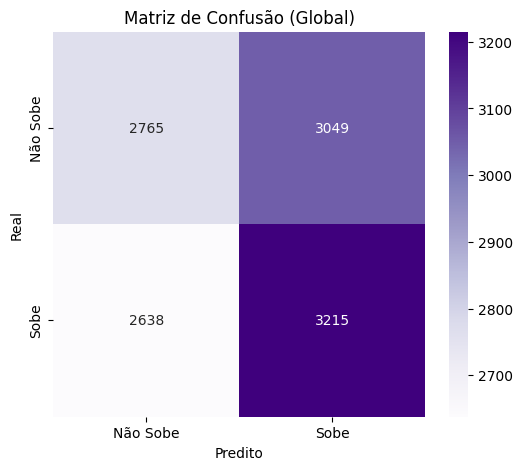


Feature: 'rsi_7'
  - Intervalo de busca p/ Limite Superior (>= Q3): de 67.12 a 100.00 (passo 2)
  - Intervalo de busca p/ Limite Inferior (<= Q1): de 0.00 a 34.46 (passo 2)

Feature: 'rsi_14'
  - Intervalo de busca p/ Limite Superior (>= Q3): de 62.17 a 98.02 (passo 2)
  - Intervalo de busca p/ Limite Inferior (<= Q1): de 2.60 a 39.00 (passo 2)

Feature: 'so_d'
  - Intervalo de busca p/ Limite Superior (>= Q3): de 76.24 a 99.26 (passo 1)
  - Intervalo de busca p/ Limite Inferior (<= Q1): de 0.89 a 26.83 (passo 1)

Feature: 'macd_diff'
  - Intervalo de busca p/ Limite Superior (>= Q3): de 0.11 a 1.45 (passo 0.02)
  - Intervalo de busca p/ Limite Inferior (<= Q1): de -1.22 a -0.11 (passo 0.02)

--- OTIMIZAÇÃO DE CONDIÇÃO (Métrica: f1_score, Mín. Amostras: 100) ---
Realizando predição única no conjunto de teste para otimização...
Predição concluída. Iniciando busca por melhores condições...

--- MELHOR CONDIÇÃO ENCONTRADA ---
Condição: macd_diff > 0.71 ou macd_diff < -0.52
Número de Amos

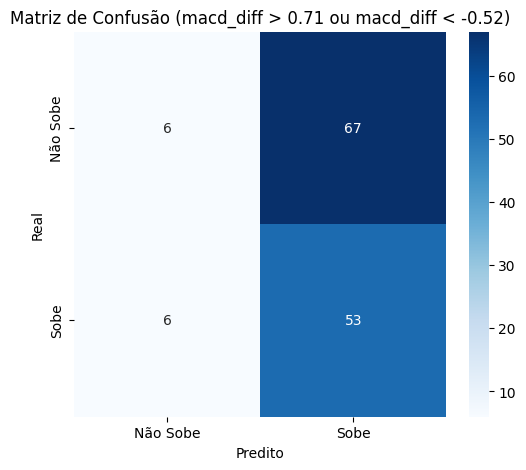

In [23]:
# PASSO 5: Avaliar o modelo
avaliar_modelo(modelo, X_test, y_test, df_features_teste)

### Visualizar o Treinamento

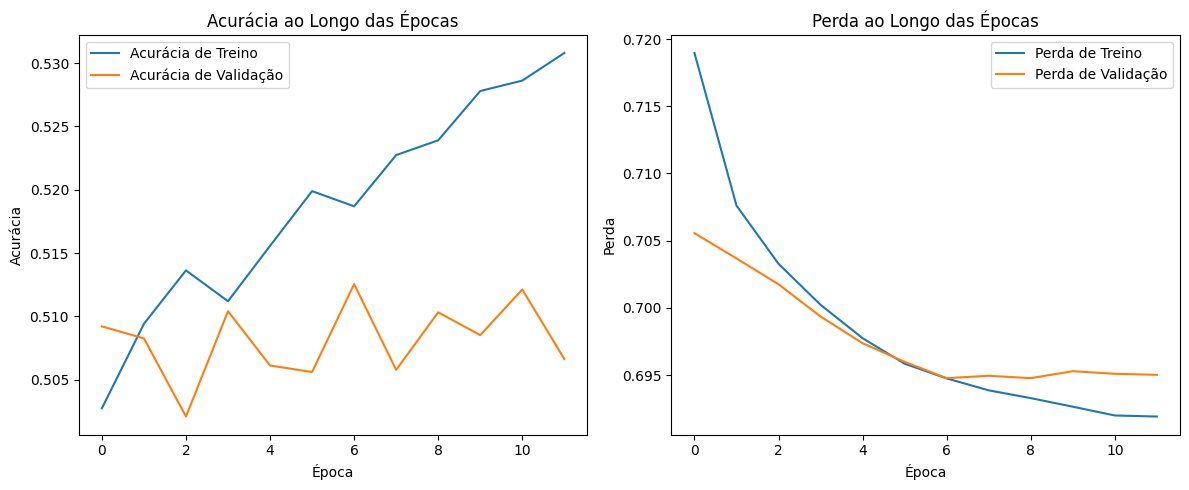

In [24]:
# PASSO 6: Visualizar o treinamento
visualizar_treinamento(historico)

### Salvar o Modelo

In [25]:
# PASSO 7: Salvar o modelo
# salvar_modelo_e_scaler(modelo, scaler)